# Imports

In [3]:
from fastai.vision import *

# Create directory and upload urls file into server

In [20]:
folder = 'British'
file = 'urls_British_Bulldog.csv'

In [23]:
folder = 'French'
file = 'urls_French_Bulldog.csv'

In [26]:
folder = 'Pug'
file = 'urls_Pug.csv'

In [4]:
path = Path('data/Dogs')
# dest = path/folder
# dest.mkdir(parents=True, exist_ok=True)

In [14]:
path.ls()

[WindowsPath('data/Dogs/British'),
 WindowsPath('data/Dogs/French'),
 WindowsPath('data/Dogs/Pug'),
 WindowsPath('data/Dogs/urls_British_Bulldog.csv'),
 WindowsPath('data/Dogs/urls_French_Bulldog.csv'),
 WindowsPath('data/Dogs/urls_Pug.csv')]

# Download Images

In [5]:
classes = ['British', 'French', 'Pug']

In [28]:
download_images(path/file, dest, max_pics=200)

## Remove imgs that can't be opened

In [31]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

# View Data

In [34]:
doc(ImageDataBunch)

In [9]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, valid_pct=0.2, ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [45]:
data.classes

['British', 'French', 'Pug']

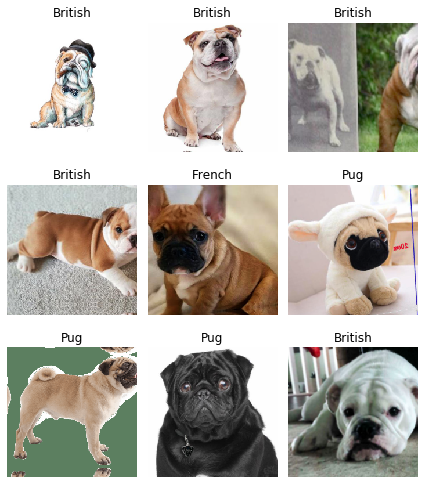

In [46]:
data.show_batch(rows=3, figsize=(6,7))

In [48]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['British', 'French', 'Pug'], 3, 353, 88)

# Train Model

In [11]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [12]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.438532,0.409118,0.170455,00:08
1,0.849076,0.152070,0.056818,00:05
2,0.584269,0.140250,0.056818,00:05
3,0.458849,0.141509,0.056818,00:05


In [13]:
learn.save('stage-1')

In [19]:
learn.unfreeze()

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


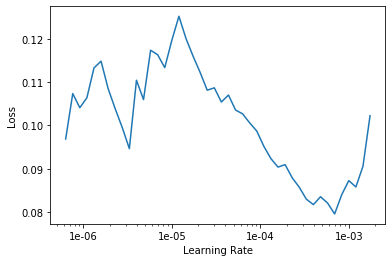

In [16]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(4, max_lr=slice(8e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.184405,0.453862,0.125000,00:06
1,0.320381,1.736291,0.170455,00:06
2,0.466095,5.882960,0.272727,00:06
3,0.461137,1.206594,0.136364,00:06


# Interpretation

In [21]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (353 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Pug,Pug,Pug,Pug,Pug
Path: data/Dogs;

Valid: LabelList (88 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Pug,British,French,French,British
Path: data/Dogs;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

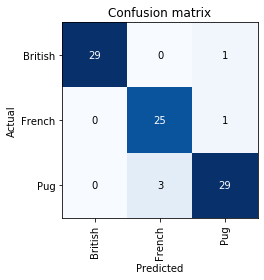

In [28]:
interp.plot_confusion_matrix()
plt.autoscale()

# Cleaning

In [29]:
from fastai.widgets import *

In [30]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [31]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

In [32]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [33]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [34]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [36]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

# Putting model in production

In [38]:
learn.export()

In [39]:
defaults.device = torch.device('cpu')

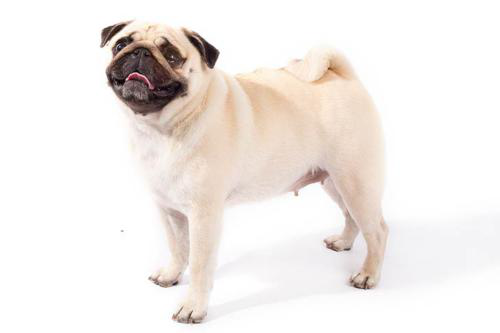

In [40]:
img = open_image(path/'Pug'/'00000001.jpg')
img

In [41]:
learn = load_learner(path)

In [42]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

Category Pug